In [1]:
import ae
import tensorflow as tf
import os
import seaborn as sns
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from audioop import rms
from matplotlib.pyplot import ylabel
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2022-11-14 04:44:37.100005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 04:44:37.428565: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-14 04:44:38.279243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:/home/can/thesis_ws/devel/lib:/home/can/bfmc_ws/devel/lib:/opt/ros/noetic/lib
2022-11-14 04:44:38.279404: W tensorflow/stream_executor/platform/default/dso_loader.

In [2]:
def testset(test_path, model, dmg=False):
    ae_test = ae.autoEncoder()
    data = []
    names = []
    imgHeight = 48
    imgWidth = 48
    imgChannel = 3
    img_shape = (imgHeight, imgWidth, imgChannel)
    ts_db = os.path.join(test_path)
    for img in os.listdir(ts_db):
        image = Image.open(os.path.join(ts_db, img)).convert('RGB')
        image = image.resize((imgHeight,imgWidth))
        image = np.array(image)
        image = image/255.0
        data.append(image)
        if dmg:
            names.append(img)
    test_data = np.array(data)
    gen = model.predict(test_data)
    tensor_test = tf.convert_to_tensor(test_data, dtype=tf.float32)
    ssim_vals = []
    psnr_vals = []
    rmse_vals = []
    mre_vals = []
    for i in range(len(test_data)):
        ssim_val = ae_test.compMetric(tensor_test[i], gen[i], "SSIM")
        psnr_val = ae_test.compMetric(tensor_test[i], gen[i], "PSNR")
        rmse_val = ae_test.compMetric(tensor_test[i], gen[i], "RMSE")
        mre_val = ae_test.compMetric(tensor_test[i], gen[i], "MRE")

        ssim_vals.append(ssim_val)
        psnr_vals.append(psnr_val/255.0)
        rmse_vals.append(rmse_val)
        mre_vals.append(mre_val)

        if dmg:
            print('Image',names[i],'ssim: ',float(ssim_val),' psnr: ', float(psnr_val/255.0), ' rmse: ', float(rmse_val), ' mre: ', mre_val)

    if dmg == False:
        print("#Instances: ", len(ssim_vals))
    return ssim_vals, psnr_vals, rmse_vals, mre_vals

def visualize(ssim_vals, psnr_vals, rmse_vals, mre_vals, sign):
    std_ssim = np.std(ssim_vals)
    mean_ssim = np.mean(ssim_vals)

    std_psnr = np.std(psnr_vals)
    mean_psnr = np.mean(psnr_vals)

    std_rmse = np.std(rmse_vals)
    mean_rmse = np.mean(rmse_vals)

    std_mre = np.std(mre_vals)
    mean_mre = np.mean(mre_vals)


    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    fig.suptitle('Image Comparison Metrics Distributions of Sign '+sign)


    ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
                color = 'darkblue',
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4, 'color': 'orange'})

    ax.set(xlabel = 'SSIM Distance', ylabel = "#Instances")

    print("ssim mean: ", mean_ssim, " ssim \u03C3: ", std_ssim, " ssim \u03BC+\u03C3: ", std_ssim+mean_ssim)
    print("ssim \u03BC+1.5\u03C3: ", (1.5)*std_ssim+mean_ssim, " ssim \u03BC+2\u03C3: ", (2.0)*std_ssim+mean_ssim)
    ax.axvline(mean_ssim, color='red', linewidth=2)
    ax.axvline(std_ssim+mean_ssim, color='green', linewidth=2)
    ax.axvline((1.5)*std_ssim+mean_ssim, color='yellow', linewidth=2)
    ax.axvline((2.0)*std_ssim+mean_ssim, color='purple', linewidth=2)


    ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
                color = 'darkblue',
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4, 'color': 'orange'})

    ax.set(xlabel = 'PSNR Distance', ylabel = "#Instances")
    print("psnr mean: ", mean_psnr, " psnr \u03C3: ", std_psnr, " psnr \u03BC+\u03C3: ", std_psnr+mean_psnr)
    print("psnr \u03BC+1.5\u03C3: ", (1.5)*std_psnr+mean_psnr, " psnr \u03BC+2\u03C3: ", (2.0)*std_psnr+mean_psnr)
    ax.axvline(mean_psnr, color='red', linewidth=2)
    ax.axvline(std_psnr+mean_psnr, color='green', linewidth=2)
    ax.axvline((1.5)*std_psnr+mean_psnr, color='yellow', linewidth=2)
    ax.axvline((2.0)*std_psnr+mean_psnr, color='purple', linewidth=2)

    ax = sns.distplot(rmse_vals, hist=True, kde=True, ax=axes[1,0],
                color = 'darkblue',
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4, 'color': 'orange'})

    ax.set(xlabel = 'RMSE Distance', ylabel = "#Instances")
    print("rmse mean: ", mean_rmse, " rmse \u03C3: ", std_rmse, " rmse \u03BC+\u03C3: ", std_rmse+mean_rmse)
    print("rmse \u03BC+1.5\u03C3: ", (1.5)*std_rmse+mean_rmse, " rmse \u03BC+2\u03C3: ", (2.0)*std_rmse+mean_rmse)
    ax.axvline(mean_rmse, color='red', linewidth=2)
    ax.axvline(std_rmse+mean_rmse, color='green', linewidth=2)
    ax.axvline((1.5)*std_rmse+mean_rmse, color='yellow', linewidth=2)
    ax.axvline((2.0)*std_rmse+mean_rmse, color='purple', linewidth=2)

    ax = sns.distplot(mre_vals, hist=True, kde=True, ax=axes[1,1],
                color = 'darkblue',
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4, 'color': 'orange'})

    ax.set(xlabel = 'MRE Distance', ylabel = "#Instances")
    print("mre mean: ", mean_mre, " mre \u03C3: ", std_mre, " mre \u03BC+\u03C3: ", std_mre+mean_mre)
    print("mre \u03BC+1.5\u03C3: ", (1.5)*std_mre+mean_mre, " mre \u03BC+2\u03C3: ", (2.0)*std_mre+mean_mre)
    ax.axvline(mean_mre, color='red', linewidth=2)
    ax.axvline(std_mre+mean_mre, color='green', linewidth=2)
    ax.axvline((1.5)*std_mre+mean_mre, color='yellow', linewidth=2)
    ax.axvline((2.0)*std_mre+mean_mre, color='purple', linewidth=2)



In [3]:
weight_file_cropped_all = "/home/can/thesis/ae_weights/cropped_allfullmodel1mse.h5"
ae_cropped_all = ae.autoEncoder()
model_cropped_all= ae_cropped_all.loadModel(weight_file_cropped_all)

test_path1 = "/home/can/thesis/gtsrb/damaged_signs/1/syn1/"
test_path9 = "/home/can/thesis/gtsrb/damaged_signs/9/syn1/"
test_path14 = "/home/can/thesis/gtsrb/damaged_signs/14/syn1/"
test_path17 = "/home/can/thesis/gtsrb/damaged_signs/17/syn1/"
test_path25 = "/home/can/thesis/gtsrb/damaged_signs/25/syn1/"
test_path39 = "/home/can/thesis/gtsrb/damaged_signs/39/syn1/"

test_path1_dmg = "/home/can/thesis/gtsrb/damaged_signs/1/dmg/"
test_path9_dmg = "/home/can/thesis/gtsrb/damaged_signs/9/dmg/"
test_path14_dmg = "/home/can/thesis/gtsrb/damaged_signs/14/dmg/"
test_path17_dmg = "/home/can/thesis/gtsrb/damaged_signs/17/dmg/"
test_path25_dmg = "/home/can/thesis/gtsrb/damaged_signs/25/dmg/"
test_path39_dmg = "/home/can/thesis/gtsrb/damaged_signs/39/dmg/"

2022-11-14 04:44:39.902172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 04:44:39.922436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 04:44:39.922595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 04:44:39.923644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2022-11-14 04:44:42.579237: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-11-14 04:44:43.454982: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


23/23 [==============================] - 2s 6ms/step
#Instances:  720
Destructor called, Employee deleted.
ssim mean:  0.23737005160914526  ssim σ:  0.08930698212769476  ssim μ+σ:  0.32667703373684004
ssim μ+1.5σ:  0.3713305248006874  ssim μ+2σ:  0.4159840158645348
psnr mean:  0.2715539755852394  psnr σ:  0.01496497878225002  psnr μ+σ:  0.2865189543674894
psnr μ+1.5σ:  0.2940014437586144  psnr μ+2σ:  0.3014839331497395
rmse mean:  0.09605539  rmse σ:  0.038067117  rmse μ+σ:  0.1341225
rmse μ+1.5σ:  0.15315606445074081  rmse μ+2σ:  0.1721896231174469
mre mean:  0.2914938  mre σ:  0.09578148  mre μ+σ:  0.38727528
mre μ+1.5σ:  0.43516602739691734  mre μ+2σ:  0.48305676877498627


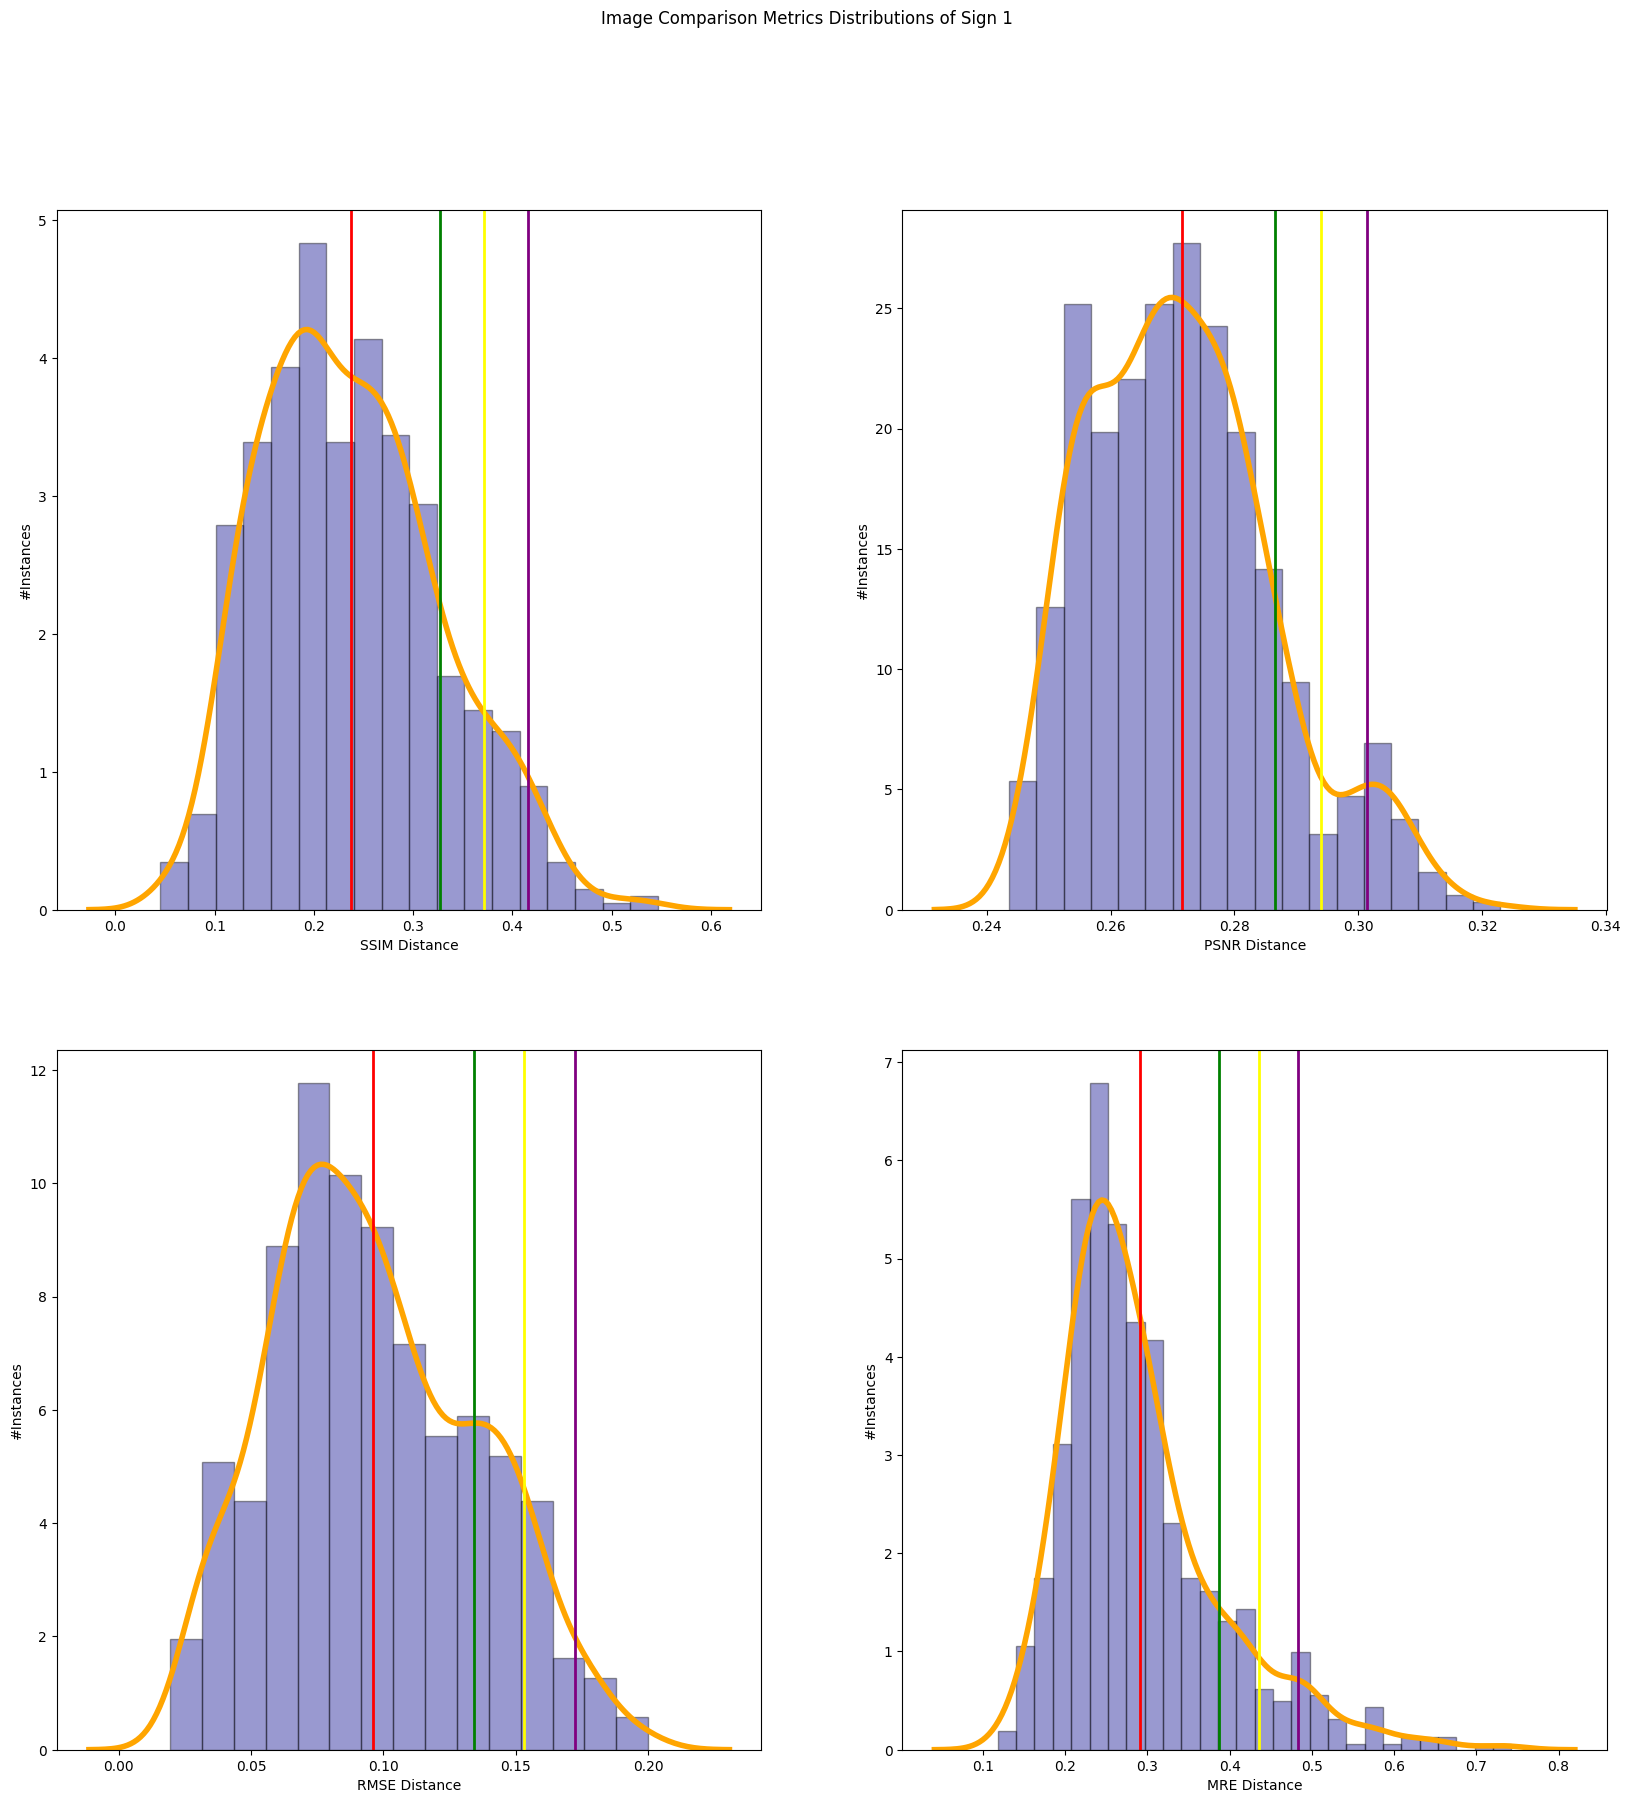

In [4]:
ssim1, psnr1, rmse1, mre1 = testset(test_path1, model_cropped_all)
visualize(ssim1, psnr1, rmse1, mre1, "1")
# _,_,_,_ = testset(test_path1_dmg, model_cropped_all,True)


15/15 [==============================] - 0s 3ms/step
#Instances:  480
Destructor called, Employee deleted.
ssim mean:  0.2172450323899587  ssim σ:  0.08904510327265959  ssim μ+σ:  0.3062901356626183
ssim μ+1.5σ:  0.3508126872989481  ssim μ+2σ:  0.3953352389352779
psnr mean:  0.28740895137288214  psnr σ:  0.019101011478344546  psnr μ+σ:  0.30650996285122667
psnr μ+1.5σ:  0.31606046859039894  psnr μ+2σ:  0.3256109743295712
rmse mean:  0.06351069  rmse σ:  0.0318367  rmse μ+σ:  0.09534739
rmse μ+1.5σ:  0.1112657431513071  rmse μ+2σ:  0.12718409299850464
mre mean:  0.28105304  mre σ:  0.1059771  mre μ+σ:  0.38703012
mre μ+1.5σ:  0.4400186911225319  mre μ+2σ:  0.49300724267959595


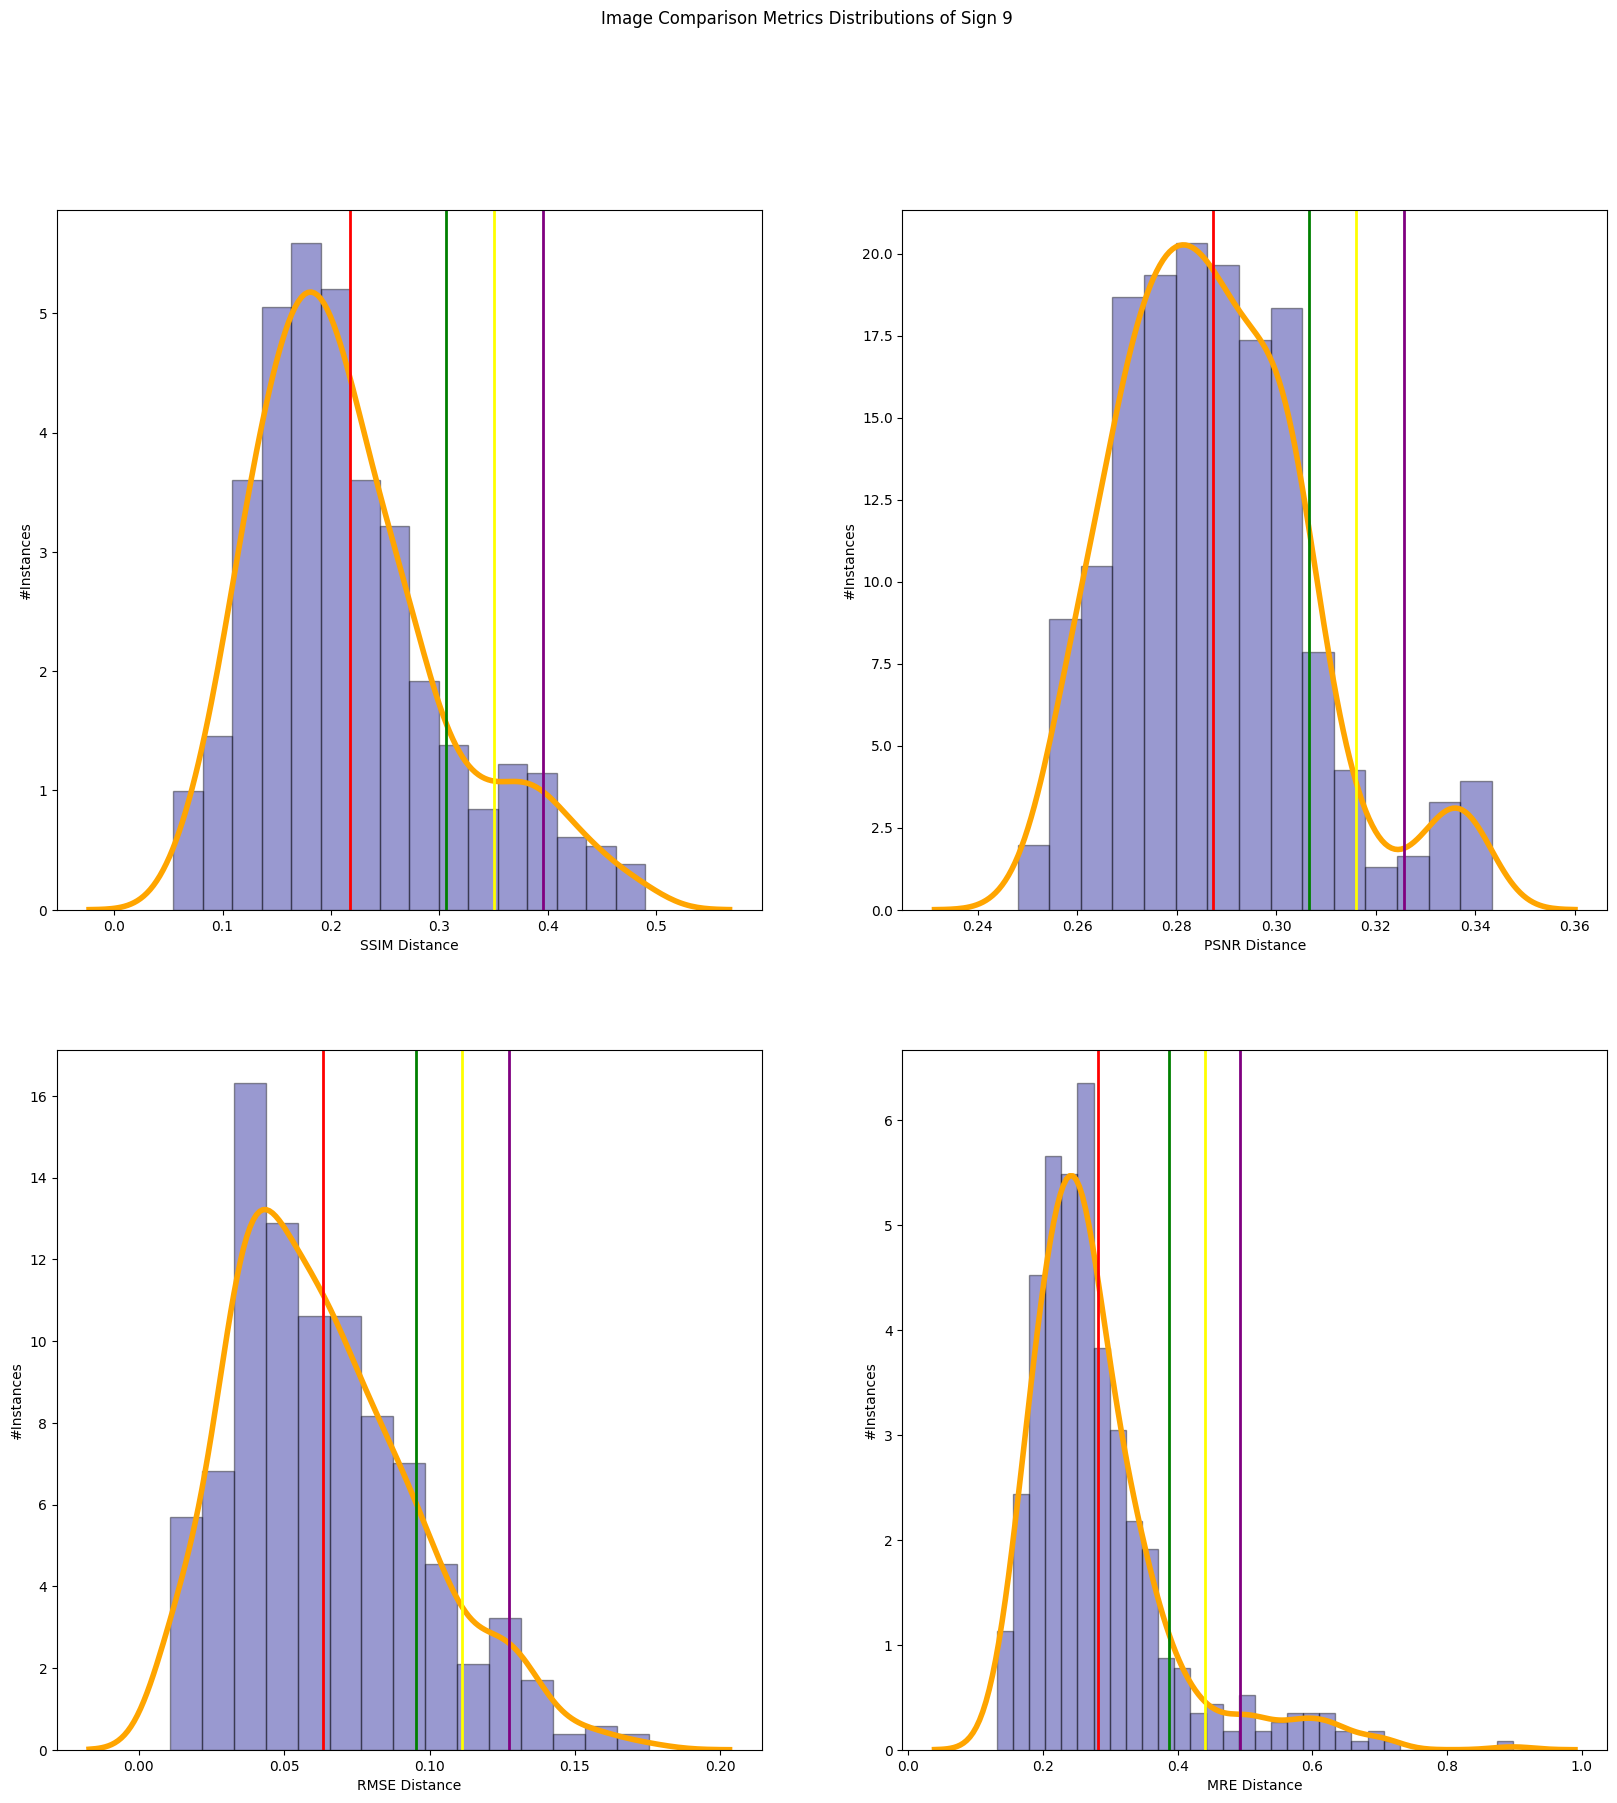

In [5]:
ssim9, psnr9, rmse9, mre9 = testset(test_path9, model_cropped_all)
visualize(ssim9, psnr9, rmse9, mre9,"9")
# _,_,_,_ = testset(test_path9_dmg, model_cropped_all,True)

9/9 [==============================] - 0s 10ms/step
#Instances:  270
Destructor called, Employee deleted.
ssim mean:  0.2872773649515929  ssim σ:  0.10584515963113153  ssim μ+σ:  0.39312252458272445
ssim μ+1.5σ:  0.4460451043982902  ssim μ+2σ:  0.49896768421385596
psnr mean:  0.2748090947081234  psnr σ:  0.015088886212290117  psnr μ+σ:  0.2898979809204135
psnr μ+1.5σ:  0.2974424240265586  psnr μ+2σ:  0.3049868671327037
rmse mean:  0.086819366  rmse σ:  0.031115955  rmse μ+σ:  0.11793532
rmse μ+1.5σ:  0.1334932977333665  rmse μ+2σ:  0.1490512751042843
mre mean:  0.32699957  mre σ:  0.09333707  mre μ+σ:  0.42033663
mre μ+1.5σ:  0.4670051746070385  mre μ+2σ:  0.5136737078428268


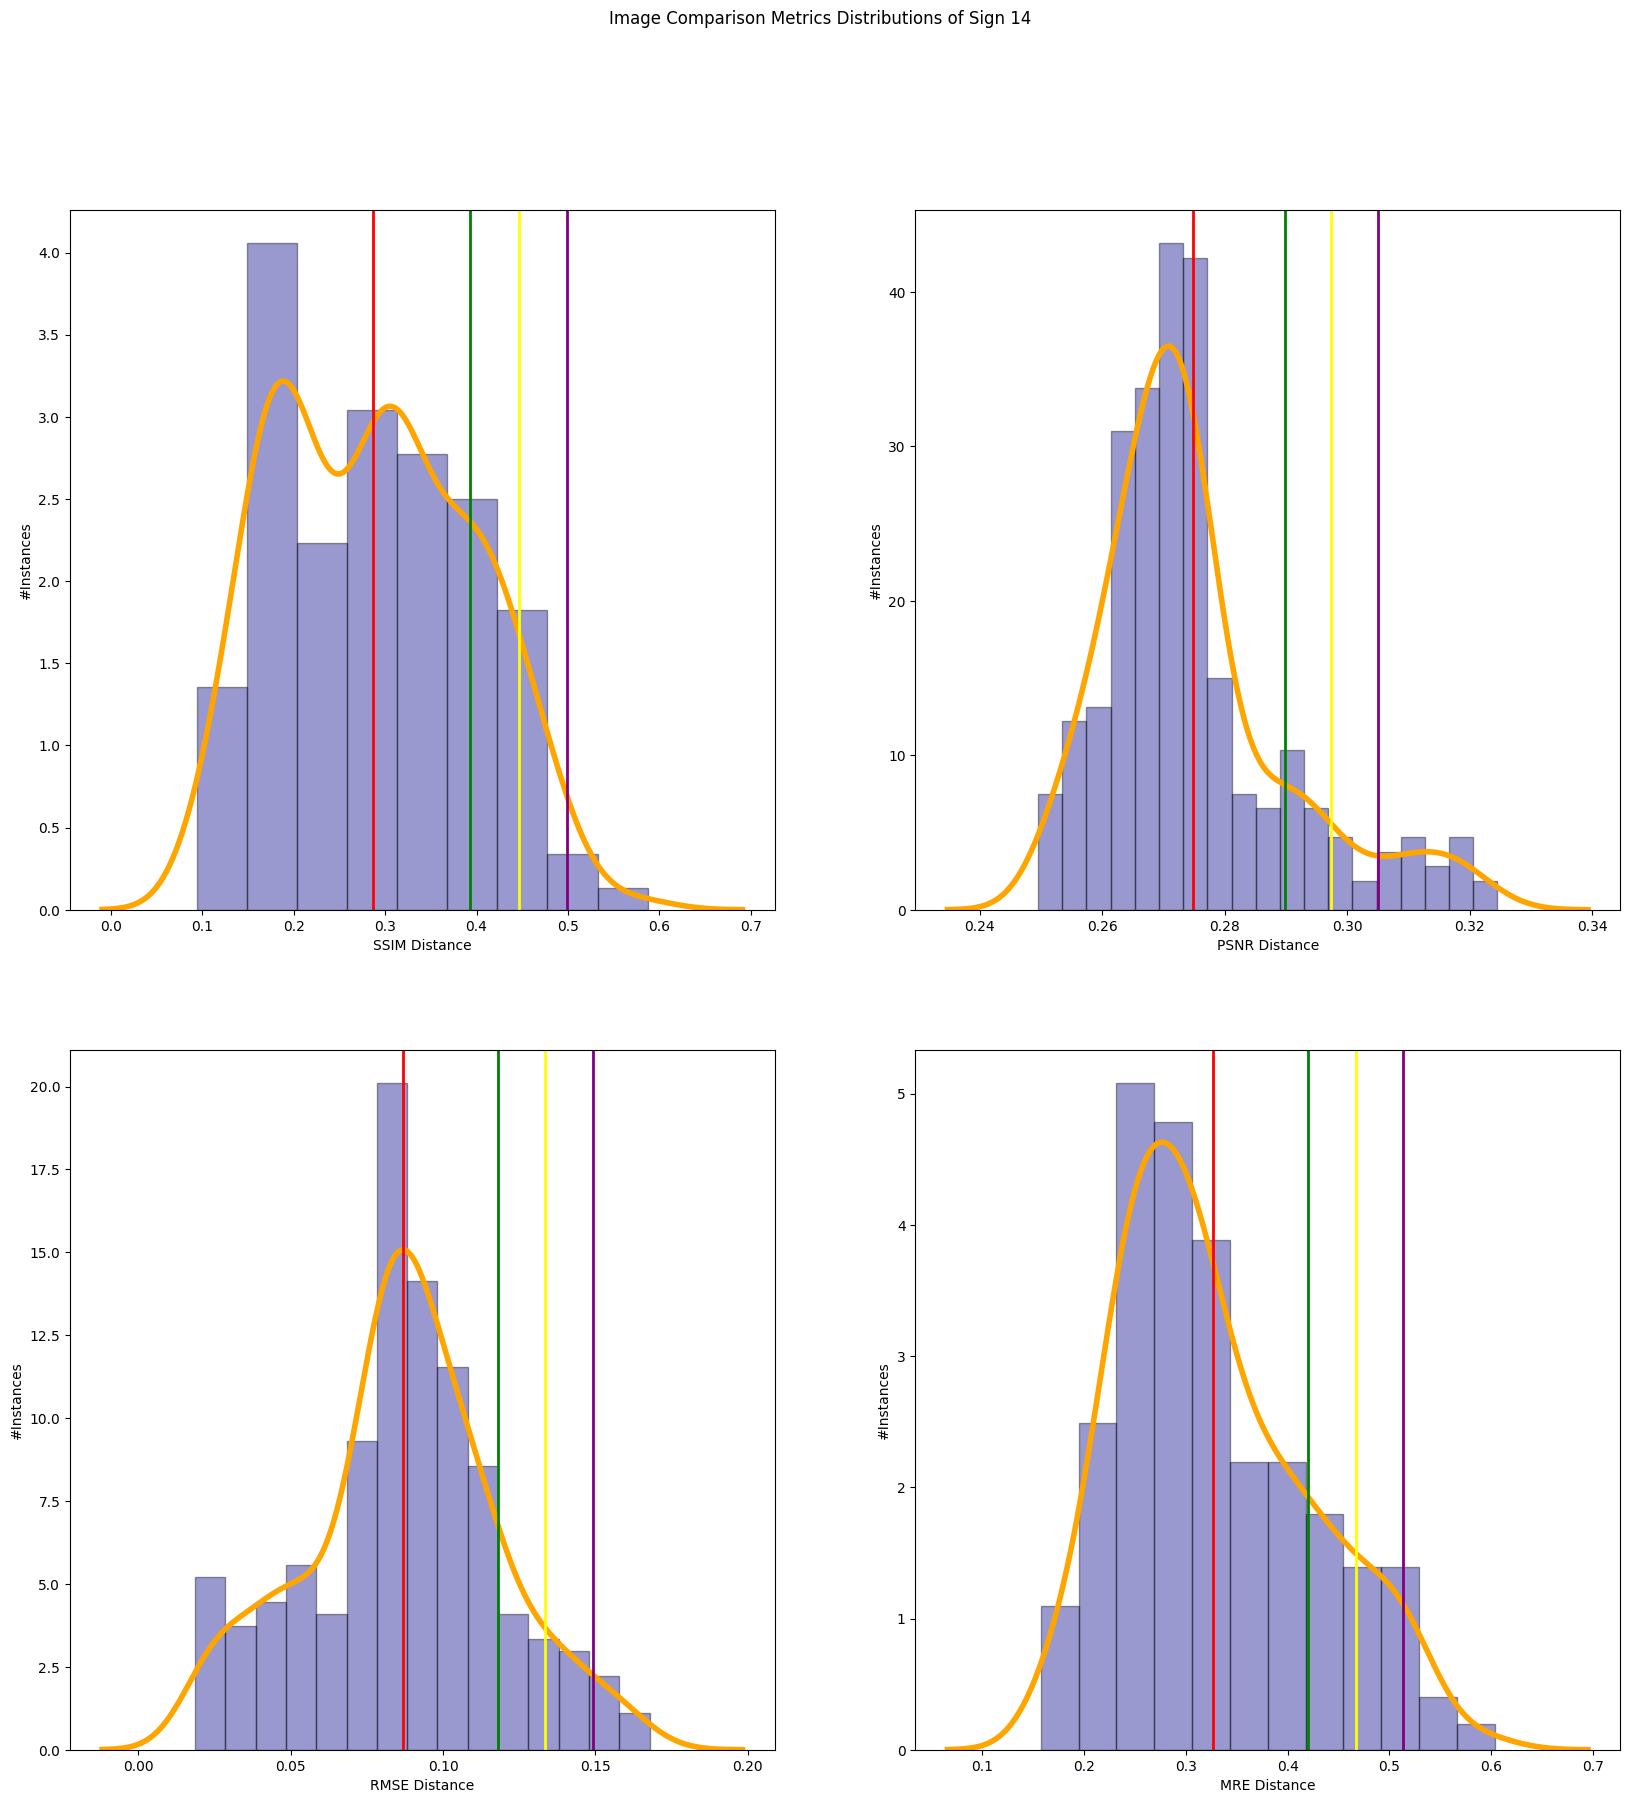

In [6]:
ssim14, psnr14, rmse14, mre14 = testset(test_path14, model_cropped_all)
visualize(ssim14, psnr14, rmse14, mre14,"14")
# _,_,_,_ = testset(test_path14_dmg, model_cropped_all,True)

12/12 [==============================] - 0s 9ms/step
#Instances:  360
Destructor called, Employee deleted.
ssim mean:  0.3100533104605145  ssim σ:  0.10025035444230834  ssim μ+σ:  0.41030366490282283
ssim μ+1.5σ:  0.460428842123977  ssim μ+2σ:  0.5105540193451312
psnr mean:  0.2691283814008459  psnr σ:  0.013973359113546758  psnr μ+σ:  0.28310174051439263
psnr μ+1.5σ:  0.29008842007116603  psnr μ+2σ:  0.2970750996279394
rmse mean:  0.10195848  rmse σ:  0.036926515  rmse μ+σ:  0.13888499
rmse μ+1.5σ:  0.15734825655817986  rmse μ+2σ:  0.1758115142583847
mre mean:  0.31364954  mre σ:  0.1336216  mre μ+σ:  0.44727114
mre μ+1.5σ:  0.5140819400548935  mre μ+2σ:  0.5808927416801453


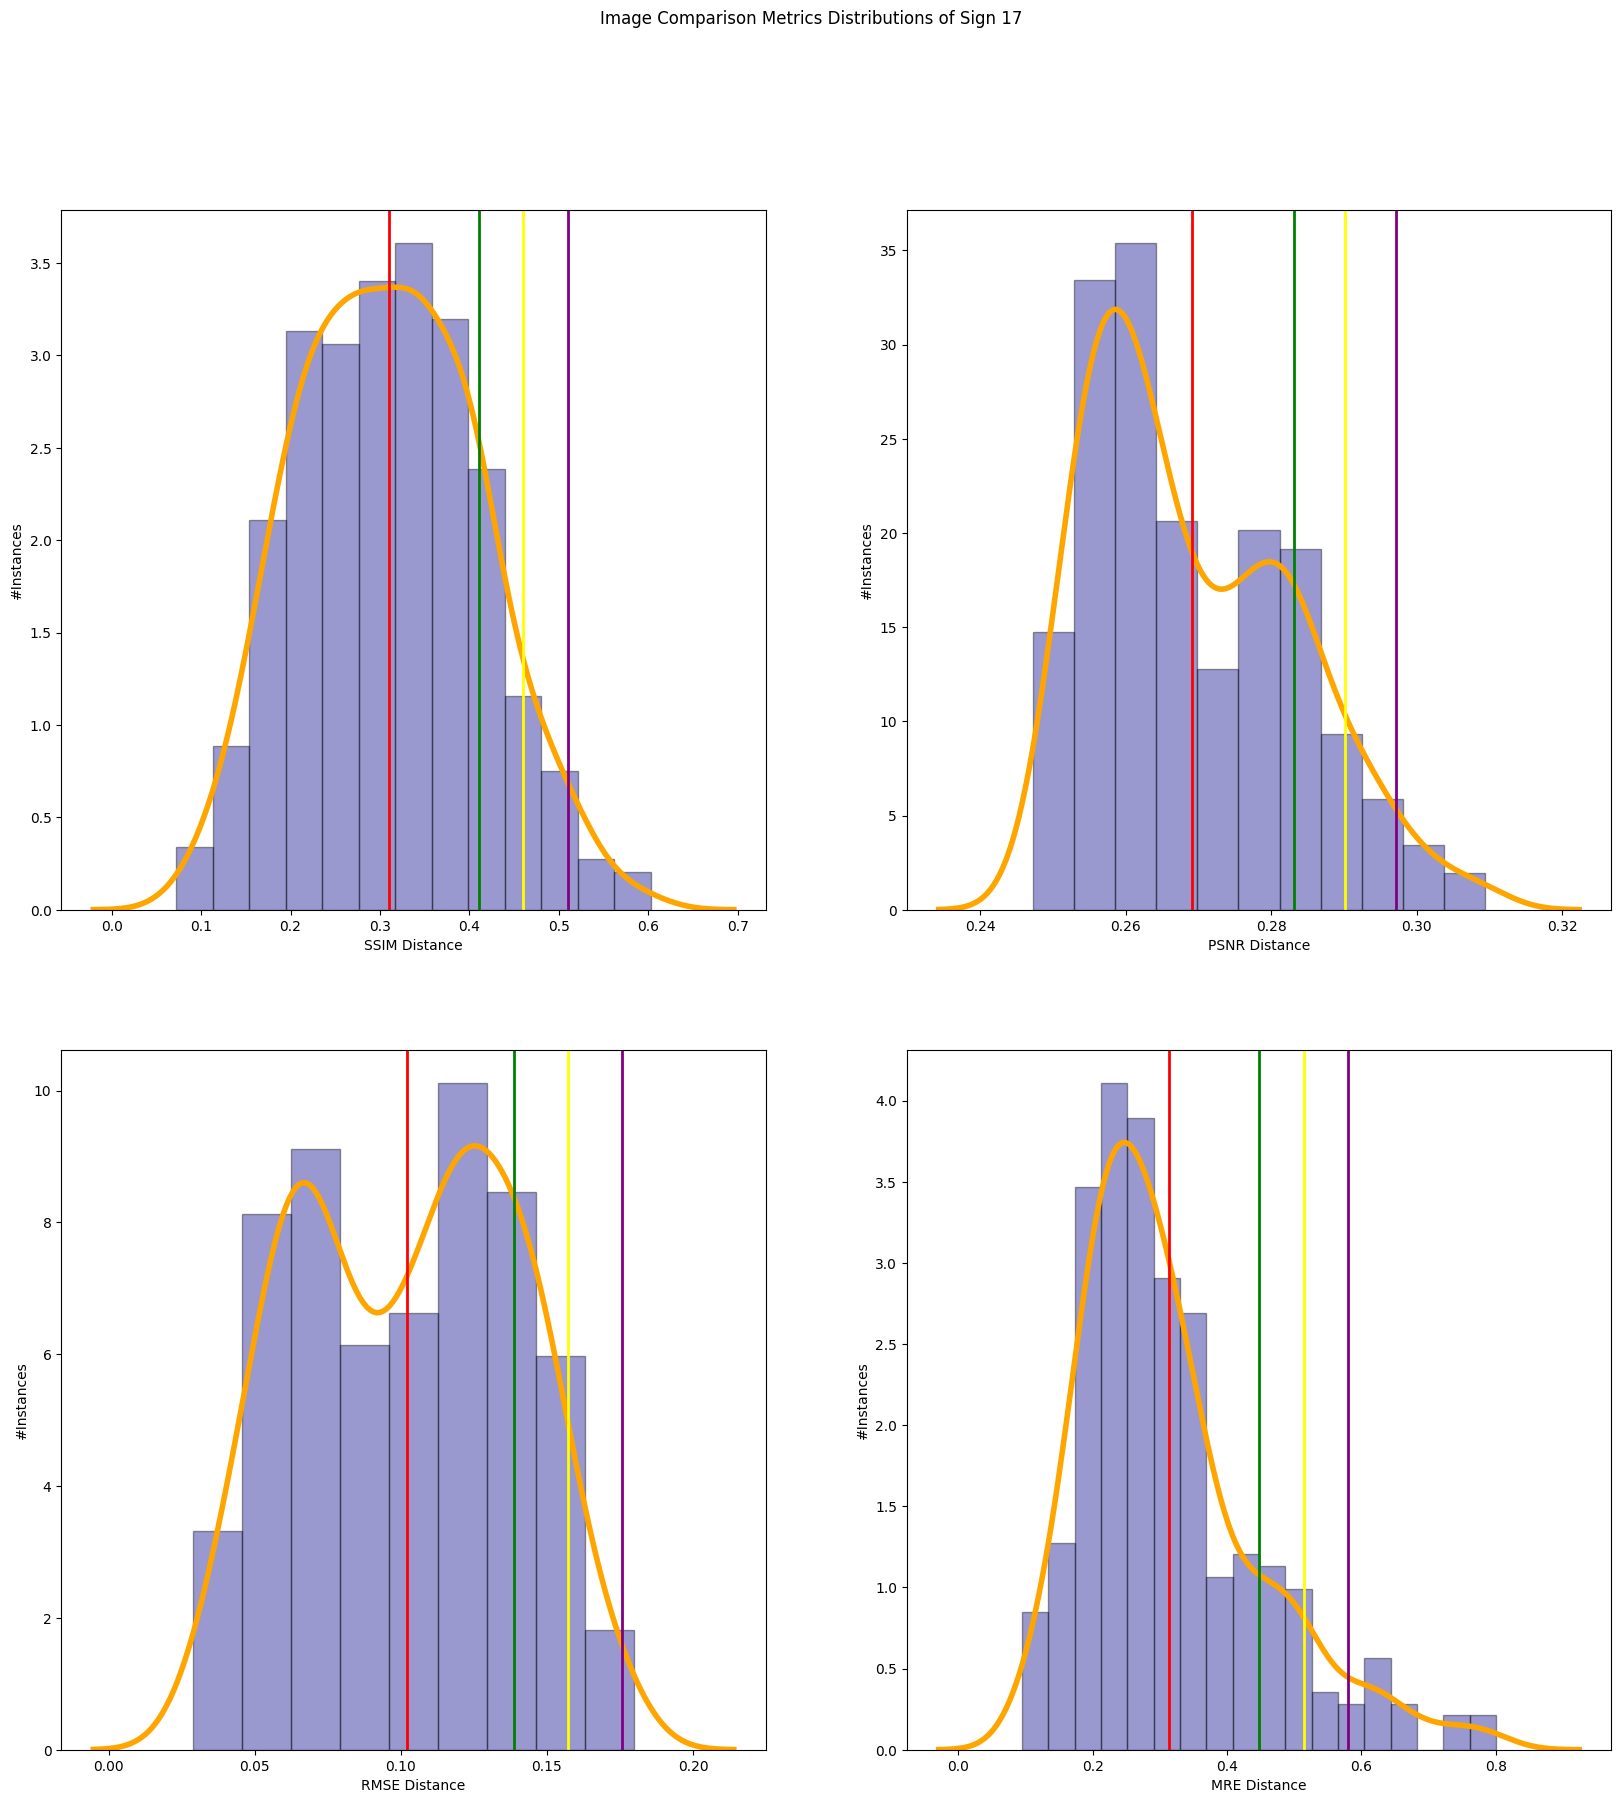

In [7]:
ssim17, psnr17, rmse17, mre17 = testset(test_path17, model_cropped_all)
visualize(ssim17, psnr17, rmse17, mre17,"17")
# _,_,_,_ = testset(test_path17_dmg, model_cropped_all,True)

15/15 [==============================] - 0s 3ms/step
#Instances:  480
Destructor called, Employee deleted.
ssim mean:  0.3091719894980391  ssim σ:  0.09666740599096503  ssim μ+σ:  0.4058393954890041
ssim μ+1.5σ:  0.4541730984844866  ssim μ+2σ:  0.5025068014799692
psnr mean:  0.2686950632170136  psnr σ:  0.016691150504607222  psnr μ+σ:  0.2853862137216208
psnr μ+1.5σ:  0.29373178897392443  psnr μ+2σ:  0.30207736422622805
rmse mean:  0.10539945  rmse σ:  0.039150015  rmse μ+σ:  0.14454946
rmse μ+1.5σ:  0.1641244739294052  rmse μ+2σ:  0.18369948118925095
mre mean:  0.3561176  mre σ:  0.10930381  mre μ+σ:  0.4654214
mre μ+1.5σ:  0.5200733207166195  mre μ+2σ:  0.5747252255678177


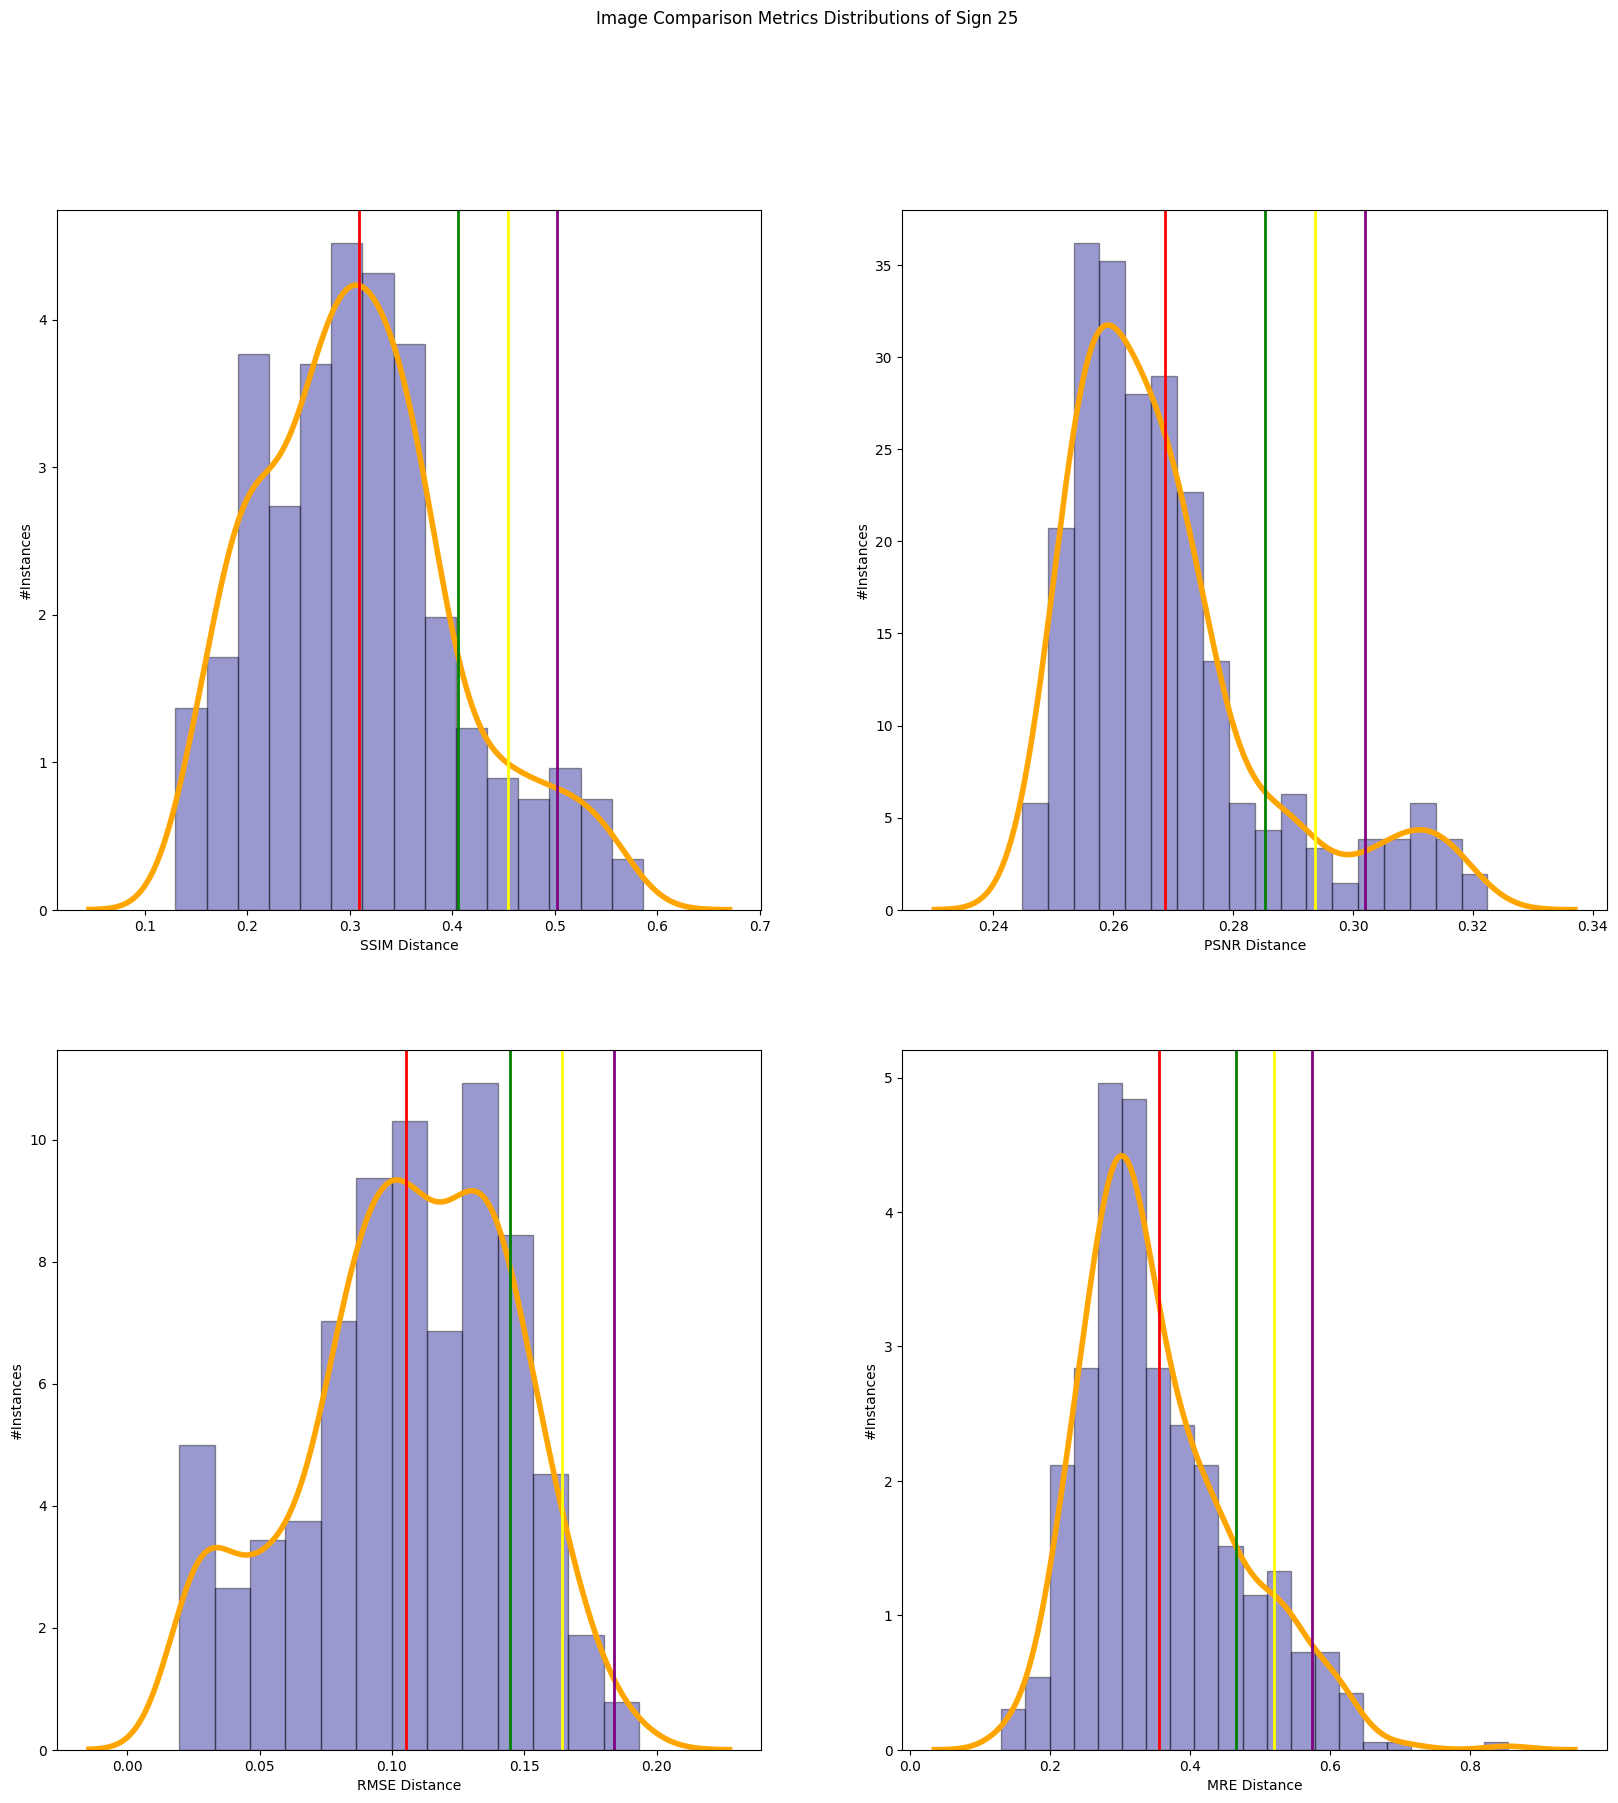

In [8]:
ssim25, psnr25, rmse25, mre25 = testset(test_path25, model_cropped_all)
visualize(ssim25, psnr25, rmse25, mre25,"25")
# _,_,_,_ = testset(test_path25_dmg, model_cropped_all,True)

3/3 [==============================] - 0s 33ms/step
#Instances:  90
Destructor called, Employee deleted.
ssim mean:  0.2821937067641152  ssim σ:  0.11319498447794502  ssim μ+σ:  0.3953886912420602
ssim μ+1.5σ:  0.4519861834810327  ssim μ+2σ:  0.5085836757200053
psnr mean:  0.27741658412293413  psnr σ:  0.02964174746772395  psnr μ+σ:  0.3070583315906581
psnr μ+1.5σ:  0.3218792053245201  psnr μ+2σ:  0.336700079058382
rmse mean:  0.09882887  rmse σ:  0.05716754  rmse μ+σ:  0.15599641
rmse μ+1.5σ:  0.18458017893135548  rmse μ+2σ:  0.21316394954919815
mre mean:  0.30673847  mre σ:  0.097057365  mre μ+σ:  0.40379584
mre μ+1.5σ:  0.4523245133459568  mre μ+2σ:  0.5008531957864761


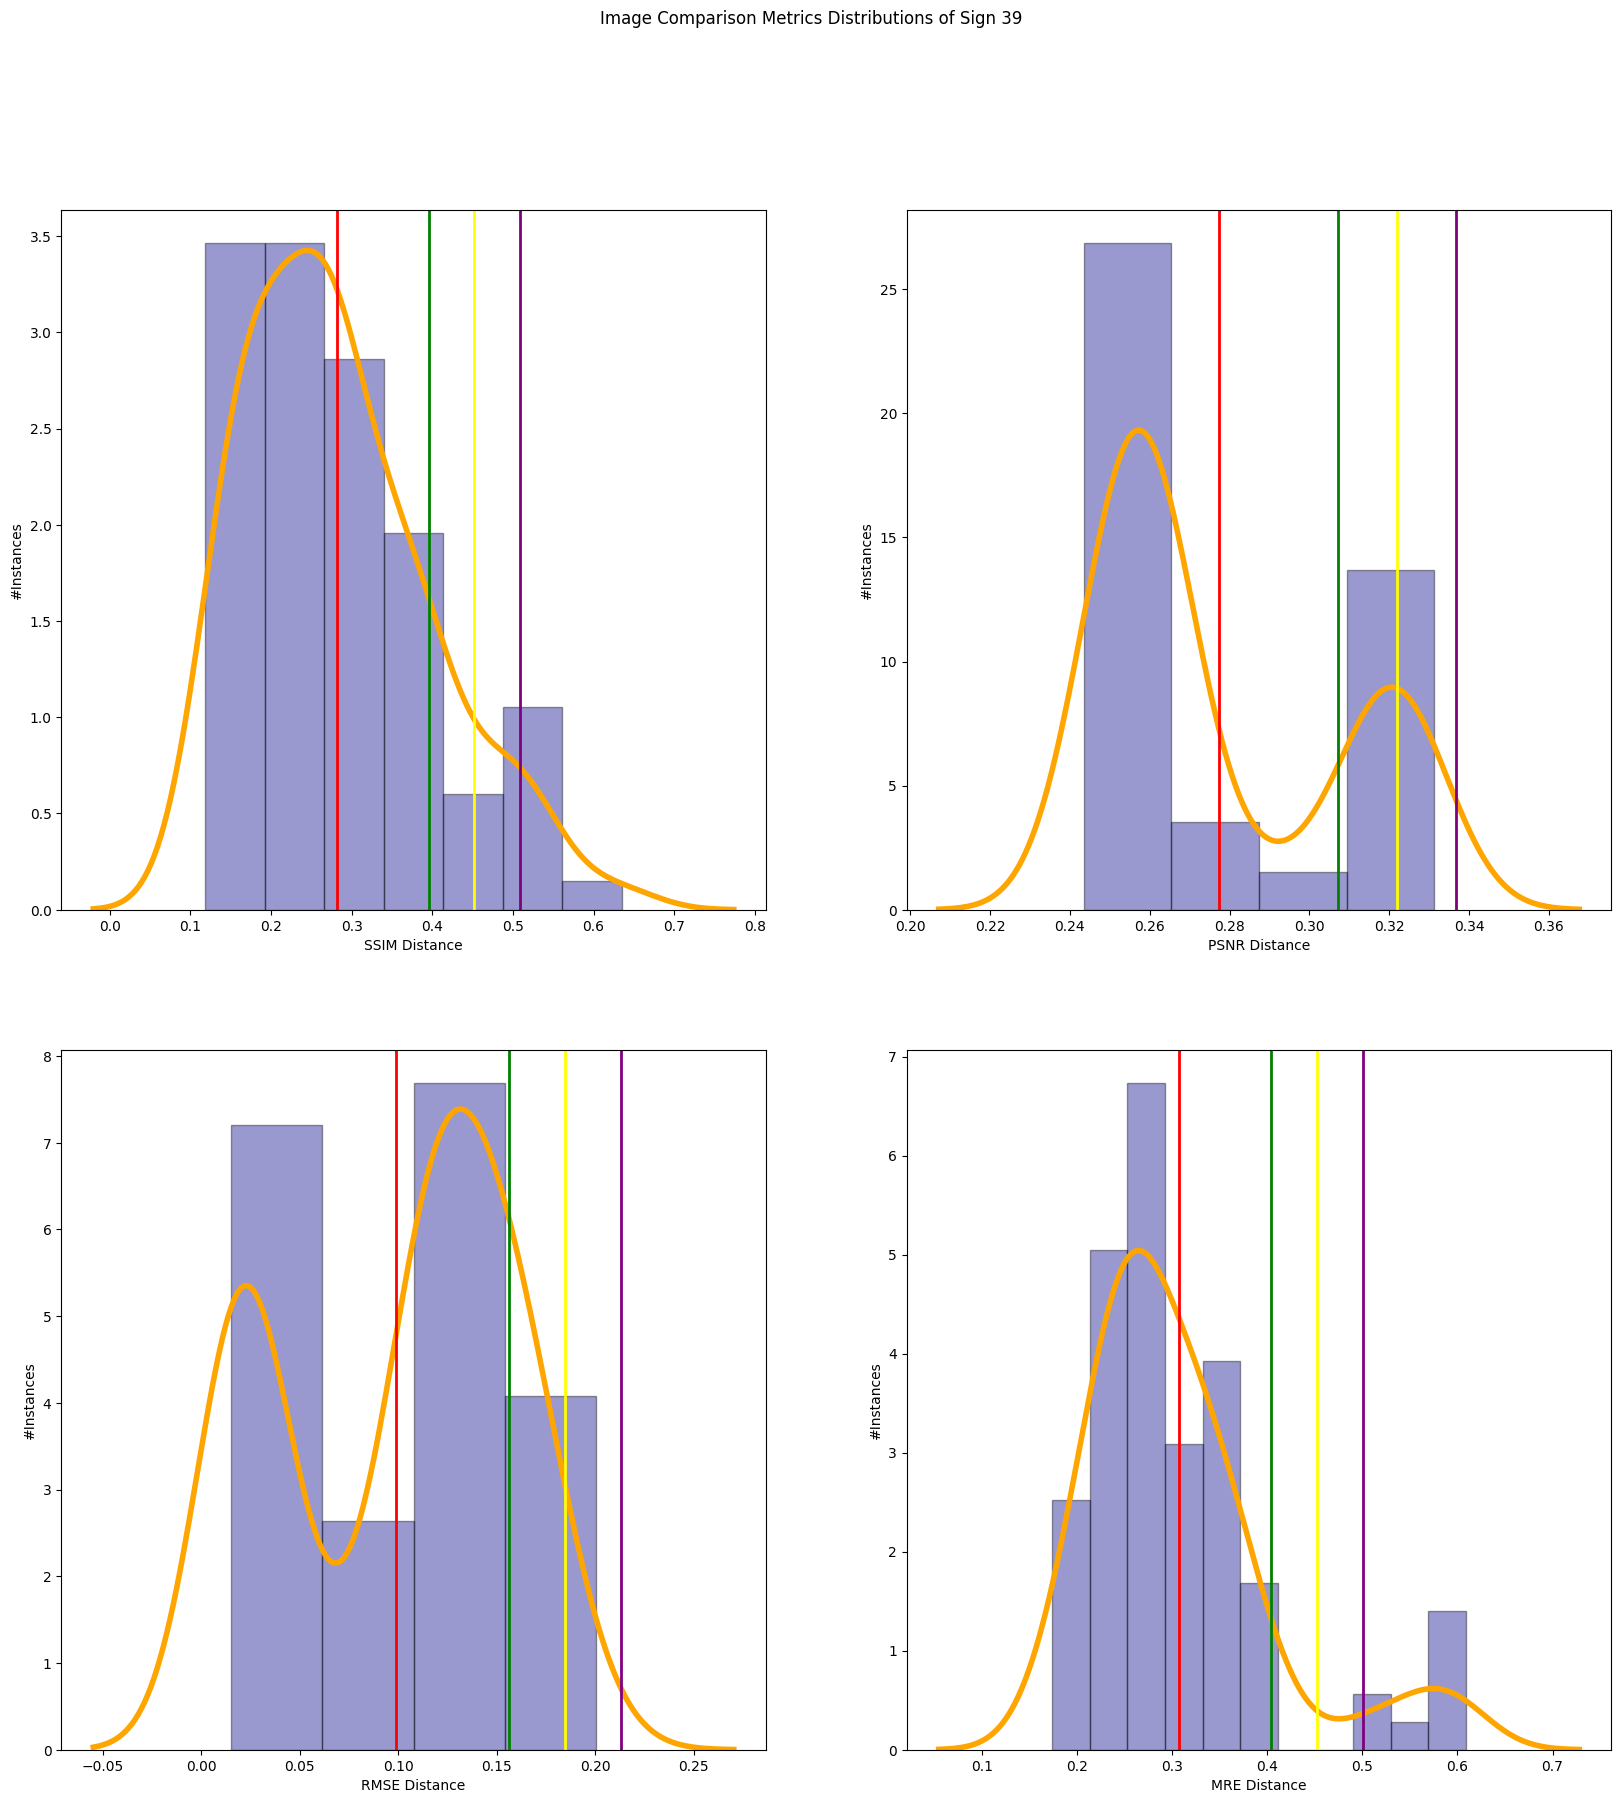

In [9]:
ssim39, psnr39, rmse39, mre39 = testset(test_path39, model_cropped_all)
visualize(ssim39, psnr39, rmse39, mre39,"39")
# _,_,_,_ = testset(test_path39_dmg, model_cropped_all,True)